#  Classification and Visual Search





<a name='0'></a>
## Imports

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset
import unittests

In [2]:
import torch
import torchvision.utils as vutils
from IPython.display import display
from torchvision import transforms
import torchinfo
import copy

In [3]:
import helper_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1 - Building a Fashion Item Classifier



In [4]:
# Compose the transformations for training: resize, augment, then preprocess
train_transform = transforms.Compose([
    # Resize images to a consistent square size (64x64 pixels)
    transforms.Resize((64, 64)),
    # Apply random horizontal flipping for data augmentation
    transforms.RandomHorizontalFlip(),
    # Apply random rotation (up to 10 degrees) for data augmentation
    transforms.RandomRotation(10),
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize tensor values to range [-1, 1] (using mean=0.5, std=0.5)
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])


# For validation: only resize and preprocess (no augmentation)
val_transform = transforms.Compose([
    # Resize images to the same consistent square size (64x64 pixels)
    transforms.Resize((64, 64)),
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize tensor values to range [-1, 1] (using mean=0.5, std=0.5)
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])

In [5]:
# Define the path to the root directory containing the dataset
dataset_path = "./clothing-dataset-small"

In [6]:
# Load the training and validation datasets
train_dataset, validation_dataset = helper_utils.load_datasets(
    # Path to the dataset directory
    dataset_path=dataset_path,
    # Apply the defined training transformations
    train_transform=train_transform,
    # Apply the defined validation transformations
    val_transform=val_transform,
    )

In [7]:
# Get the list of class names automatically inferred from the folder structure
classes = train_dataset.classes

# Get the total number of classes
num_classes = len(classes)

# Print the discovered class names
print(f"Classes: {classes}")
# Print the total count of classes
print(f"Number of classes: {num_classes}")

Classes: ['dress', 'hat', 'longsleeve', 'pants', 'shoes', 'shorts', 't-shirt']
Number of classes: 7


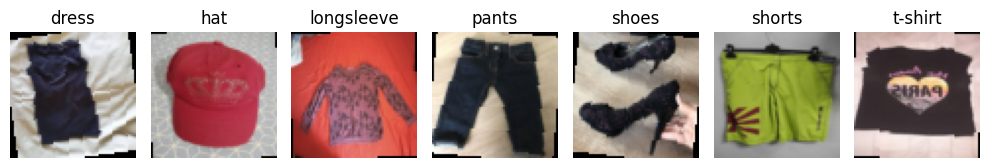

In [8]:
# Display a grid of sample images from the training dataset with their labels
helper_utils.show_sample_images(train_dataset)

* Finally, create the `DataLoader` instances for both training and validation sets. These will handle shuffling the training data and organizing the images into batches for efficient processing during model training.

In [9]:
# Create DataLoaders for managing batching and shuffling
train_loader, val_loader = helper_utils.create_dataloaders(
    # Pass the training dataset
    train_dataset=train_dataset,
    # Pass the validation dataset
    validation_dataset=validation_dataset,
    # Define the number of images per batch
    batch_size=32
)

<a name='1-3'></a>
### 1.3 - Architecting the Classifier: Efficiency with Inverted Residuals



In [ ]:


class InvertedResidualBlock(nn.Module):
    """
    Implements an inverted residual block, often used in architectures like MobileNetV2.
    
    This block features an expansion phase (1x1 convolution), a depthwise
    convolution (3x3 convolution), and a projection phase (1x1 convolution).
    It utilizes a residual connection between the input and the output of the projection.
    """
    
    def __init__(
        self, in_channels, out_channels, stride, expansion_factor, shortcut=None
    ):
        """
        Initializes the InvertedResidualBlock module.

        Args:
            in_channels: The number of channels in the input tensor.
            out_channels: The number of channels in the output tensor.
            stride (int): The stride to be used in the depthwise convolution.
            expansion_factor (int): The factor by which to expand the input channels
                                    in the expansion phase.
            shortcut: An optional module to be used for the shortcut connection,
                      typically to match dimensions if the stride is > 1 or
                      if channel counts differ.
        """
        # Initialize the parent nn.Module
        super().__init__()
        # Calculate the number of channels for the intermediate (expanded) representation
        # The hidden dimension is the expanded number of channels
        hidden_dim = in_channels * expansion_factor


        

        # Define the expansion phase, which increases channel dimension
        # Expansion phase: increases the number of channels
        self.expand = nn.Sequential(
            # 1x1 pointwise convolution
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            # Batch normalization
            nn.BatchNorm2d(hidden_dim),
            # ReLU activation
            nn.ReLU(inplace=True),
        ) 

        

        # Define the depthwise convolution phase
        # Depthwise convolution: lightweight spatial convolution per channel
        self.depthwise = nn.Sequential(
            # 3x3 depthwise convolution
            nn.Conv2d(
                in_channels=hidden_dim,
                out_channels=hidden_dim,
                kernel_size=3,
                stride=stride,
                padding=1,
                bias=False,
            ),
            # Batch normalization
            nn.BatchNorm2d(num_features=hidden_dim),
            # ReLU activation
            nn.ReLU(inplace=True),
        )

        

        # Define the projection phase, which reduces channel dimension
        # Projection phase: reduces the number of channels to out_channels
        self.project = nn.Sequential(
            # 1x1 pointwise convolution (linear)
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            # Batch normalization
            nn.BatchNorm2d(out_channels),
        ) 

        

        # Store the provided shortcut module
        # Optional shortcut connection for residual learning
        self.shortcut = shortcut

    def forward(self, x):
        """
        Defines the forward pass of the InvertedResidualBlock.

        Args:
            x: The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying the block operations
                          and the residual connection, followed by a ReLU activation.
        """

        
        
        # Store the original input for the residual connection
        # Save input for residual connection
        skip = x

        # Apply the expansion phase
        # Forward pass through the block
        # Expand channels
        out = self.expand(x)
        
        # Apply the depthwise convolution
        # Apply depthwise convolution
        out = self.depthwise(out)
        
        # Apply the projection phase
        # Project back to out_channels
        out = self.project(out)
        
        

        # Check if a separate shortcut module is defined
        # If shortcut exists (for matching dimensions), use it
        # DO NOT REMOVE `None` from the `if` condition
        if self.shortcut is not None:
            
        
            
            # Apply the shortcut module to the original input
            # Use the shortcut connection to match dimensions
            skip = self.shortcut(x)

        # Add the (potentially transformed) input (skip connection) to the output
        # Add the skip connection
        out = out + skip

             
        
        # Apply the final ReLU activation
        return F.relu(out)


In [12]:
# --- Verification ---
# Define parameters for a sample block instance
batch_size=32
in_ch = 16 # Input channels
out_ch = 16 # Output channels (same for stride=1)
stride = 1
exp_factor = 3 # Expansion factor
img_size = 32 # Input image height/width

# Instantiate the block
block = InvertedResidualBlock(
    in_channels=in_ch,
    out_channels=out_ch,
    stride=stride,
    expansion_factor=exp_factor,
)

# Define the input tensor shape
input_size = (batch_size, in_ch, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": 3 # Show layers up to 3 levels deep
}

# Generate the summary
summary = torchinfo.summary(
    model=block,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Block Summary (Stride=1, Same Channels) ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Block Summary (Stride=1, Same Channels) ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
InvertedResidualBlock (InvertedResidualBlock),"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (expand): 1-1,"[32, 16, 32, 32]","[32, 48, 32, 32]",--
Conv2d (0): 2-1,"[32, 16, 32, 32]","[32, 48, 32, 32]",768
BatchNorm2d (1): 2-2,"[32, 48, 32, 32]","[32, 48, 32, 32]",96
ReLU (2): 2-3,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Sequential (depthwise): 1-2,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Conv2d (0): 2-4,"[32, 48, 32, 32]","[32, 48, 32, 32]","20,736"
BatchNorm2d (1): 2-5,"[32, 48, 32, 32]","[32, 48, 32, 32]",96
ReLU (2): 2-6,"[32, 48, 32, 32]","[32, 48, 32, 32]",--
Sequential (project): 1-3,"[32, 48, 32, 32]","[32, 16, 32, 32]",--


#### Expected Output:

<div style="float: left;">

| Layer (type (var_name):depth-idx) | Input Shape | Output Shape | Param # |
| :--- | :--- | :--- | :--- |
| InvertedResidualBlock (InvertedResidualBlock) | [32, 16, 32, 32] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (expand): 1-1 | [32, 16, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-1 | [32, 16, 32, 32] | [32, 48, 32, 32] | 768 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-2 | [32, 48, 32, 32] | [32, 48, 32, 32] | 96 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU (2): 2-3 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (depthwise): 1-2 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-4 | [32, 48, 32, 32] | [32, 48, 32, 32] | 20,736 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-5 | [32, 48, 32, 32] | [32, 48, 32, 32] | 96 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ReLU (2): 2-6 | [32, 48, 32, 32] | [32, 48, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;Sequential (project): 1-3 | [32, 48, 32, 32] | [32, 16, 32, 32] | -- |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Conv2d (0): 2-7 | [32, 48, 32, 32] | [32, 16, 32, 32] | 768 |
| &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;BatchNorm2d (1): 2-8 | [32, 16, 32, 32] | [32, 16, 32, 32] | 32 |

</div>
<div style="clear: both;"></div>

---
**Total params:** 22,496  
**Trainable params:** 22,496  
**Non-trainable params:** 0  
**Total mult-adds:** 0.73 GB  

---
**Input size (MB):** 2.00  
**Forward/backward pass size (MB):** 56.00  
**Params size (MB):** 0.09  
**Estimated Total Size (MB):** 58.09

In [ ]:
#  MobileNetBackbone

class MobileNetBackbone(nn.Module):
    """
    Implements a simplified MobileNet-like backbone feature extractor.

    This class defines the initial stem and a sequence of inverted residual blocks
    to extract features from an input image.
    """

    def __init__(self):
        """
        Initializes the layers of the MobileNet backbone.
        """
        # Call the parent class (nn.Module) constructor
        super().__init__()
        # Define the initial "stem" convolution layer
        # This layer reduces spatial size and increases channel depth
        self.stem = nn.Sequential(
            # 3x3 convolution with stride 2
            nn.Conv2d(3, 16, 3, stride=2, padding=1, bias=False),  # 3 input channels (RGB), 16 output
            # Apply batch normalization
            nn.BatchNorm2d(16),
            # Apply ReLU activation
            nn.ReLU(inplace=True),
        )

        

        # Define the main stack of custom MobileNet-like blocks
        self.blocks = nn.Sequential(  
            # Each block progressively increases channels and reduces spatial dimensions
            # Create the first block
            self._make_block(16, 24, stride=2, expansion_factor=3),
            # Create the second block
            self._make_block(24, 32, stride=2, expansion_factor=3),
            # Create the third block
            self._make_block(32, 64, stride=2, expansion_factor=6),
        )  

        

    def _make_block(self, in_channels, out_channels, stride=1, expansion_factor=6):
        """
        Helper method to create a single InvertedResidualBlock.

        Arguments:
            in_channels: Number of input channels.
            out_channels: Number of output channels.
            stride: The stride to be used in the depthwise convolution.
            expansion_factor: The factor to expand the channels internally.
        """

        

        # Determine if a shortcut connection is needed
        # A shortcut is needed if input/output channels differ or if stride != 1
        condition = (in_channels != out_channels) or (stride != 1)

        # If a shortcut is needed
        if condition:

        

            # Define the shortcut connection
            shortcut = nn.Sequential(
                # 1x1 convolution to match dimensions and apply stride
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                # Apply batch normalization
                nn.BatchNorm2d(out_channels),
            )

        else:
            # No shortcut connection is needed
            shortcut = None

        

        # Instantiate the InvertedResidualBlock
        block = InvertedResidualBlock(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=stride,
            expansion_factor=expansion_factor,
            shortcut=shortcut,
        )

        
        
        # Return the created block
        return block

    def forward(self, x):
        """
        Defines the forward pass of the backbone.

        Arguments:
            x: The input tensor (e.g., a batch of images).

        Returns:
            The output feature map tensor.
        """
        # Pass the input through the initial stem layer
        x = self.stem(x)
        # Pass the result through the main stack of blocks
        x = self.blocks(x)

        # Return the final feature map
        return x


In [15]:
# --- Verification ---
# Define parameters for verification
batch_size=32
img_size = 64 # Input image height/width
depth = 3 # Summary depth

# Instantiate the backbone
backbone = MobileNetBackbone()

# Define the input tensor shape
input_size = (batch_size, 3, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": depth
}

# Generate the summary
summary = torchinfo.summary(
    model=backbone,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Backbone Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Backbone Summary ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
MobileNetBackbone (MobileNetBackbone),"[32, 3, 64, 64]","[32, 64, 4, 4]",--
Sequential (stem): 1-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",--
Conv2d (0): 2-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",432
BatchNorm2d (1): 2-2,"[32, 16, 32, 32]","[32, 16, 32, 32]",32
ReLU (2): 2-3,"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (blocks): 1-2,"[32, 16, 32, 32]","[32, 64, 4, 4]",--
InvertedResidualBlock (0): 2-4,"[32, 16, 32, 32]","[32, 24, 16, 16]",--
Sequential (expand): 3-1,"[32, 16, 32, 32]","[32, 48, 32, 32]",864
Sequential (depthwise): 3-2,"[32, 48, 32, 32]","[32, 48, 16, 16]","20,832"
Sequential (project): 3-3,"[32, 48, 16, 16]","[32, 24, 16, 16]","1,200"


<a name='1-4'></a>
### 1.4 - Assembling the Full Classifier

With the backbone complete, the final step is to assemble the full `MobileNetLikeClassifier`. This involves combining your `MobileNetBackbone` with a simple classification head. The head takes the feature map produced by the backbone, reduces its spatial dimensions using **Adaptive Average Pooling**, flattens the result into a vector, and finally uses a **Linear layer** to produce the raw output scores (logits) for each class.

This modular assembly highlights the power of separating feature extraction (backbone) from the final task specific layers (head), making it easy to adapt the backbone for different purposes later on.

* The `MobileNetLikeClassifier` class is provided below. Instantiate it, making sure to pass the correct `num_classes` for your dataset.

In [17]:
class MobileNetLikeClassifier(nn.Module):
    """
    A classifier model that combines a feature extraction
    backbone with a simple classification head.
    """
    
    def __init__(self, num_classes=10):
        """
        Initializes the classifier components.

        Args:
            num_classes (int): The number of output classes for the final
                               classification layer.
        """
        # Initialize the parent nn.Module
        super().__init__()

        # Backbone extracts features from input images
        self.backbone = MobileNetBackbone()

        # Head processes the features to produce class predictions
        self.head = nn.Sequential(
            # Reduce spatial dimensions to 1x1
            nn.AdaptiveAvgPool2d(1),
            # Flatten the features into a 1D vector
            nn.Flatten(),
            # Map the flattened features to the number of output classes
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        """
        Defines the forward pass of the classifier.

        Args:
            x: The input tensor (batch of images).

        Returns:
            torch.Tensor: The raw, unnormalized output scores (logits)
                          for each class.
        """
        # Pass the input through the feature extraction backbone
        x = self.backbone(x)
        # Pass the features through the classification head
        x = self.head(x)
        # Return the final output
        return x

* Instantiate the complete classifier model.

In [18]:
# Ensure num_classes matches the number of categories in your dataset
mobilenet_classifier = MobileNetLikeClassifier(num_classes=num_classes)

In [19]:
# Define parameters for verification
batch_size=32
img_size = 64 # Input image height/width
depth = 3 # Summary depth

# Define the input tensor shape
input_size = (batch_size, 3, img_size, img_size)

# Configuration for torchinfo summary
config = {
    "input_size": input_size,
    "attr_names": ["input_size", "output_size", "num_params"],
    "col_names_display": ["Input Shape ", "Output Shape", "Param #"],
    "depth": depth # Show layers up to 3 levels deep for detail
}

# Generate the summary for the complete classifier
summary = torchinfo.summary(
    model=mobilenet_classifier,
    input_size=config["input_size"],
    col_names=config["attr_names"],
    depth=config["depth"]
)

# Display the formatted summary
print("--- Classifier Summary ---\n")
helper_utils.display_torch_summary(summary, config["attr_names"], config["col_names_display"], config["depth"])

--- Classifier Summary ---



Layer (type (var_name):depth-idx),Input Shape,Output Shape,Param #
MobileNetLikeClassifier (MobileNetLikeClassifier),"[32, 3, 64, 64]","[32, 7]",--
MobileNetBackbone (backbone): 1-1,"[32, 3, 64, 64]","[32, 64, 4, 4]",--
Sequential (stem): 2-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",--
Conv2d (0): 3-1,"[32, 3, 64, 64]","[32, 16, 32, 32]",432
BatchNorm2d (1): 3-2,"[32, 16, 32, 32]","[32, 16, 32, 32]",32
ReLU (2): 3-3,"[32, 16, 32, 32]","[32, 16, 32, 32]",--
Sequential (blocks): 2-2,"[32, 16, 32, 32]","[32, 64, 4, 4]",--
InvertedResidualBlock (0): 3-4,"[32, 16, 32, 32]","[32, 24, 16, 16]","23,328"
InvertedResidualBlock (1): 3-5,"[32, 24, 16, 16]","[32, 32, 8, 8]","51,872"
InvertedResidualBlock (2): 3-6,"[32, 32, 8, 8]","[32, 64, 4, 4]","353,280"


<a name='1-5'></a>
### 1.5 - Training the Classifier



In [20]:
# Calculate class weights to handle imbalance in the dataset
class_weights = helper_utils.compute_class_weights(train_dataset)

# Move the weights tensor to the correct device (e.g., 'cuda' or 'cpu')
class_weights = class_weights.to(device)

# Define the loss function for multi-class classification, incorporating the calculated class weights
loss_fcn = nn.CrossEntropyLoss(weight=class_weights)

# Print the calculated weights for verification
print("Calculated class weights:")
for i, weight in enumerate(class_weights):
    print(f"- Class '{classes[i]}': {weight:.4f}")

Calculated class weights:
- Class 'dress': 1.4713
- Class 'hat': 2.8827
- Class 'longsleeve': 0.7793
- Class 'pants': 0.7576
- Class 'shoes': 1.7908
- Class 'shorts': 1.7553
- Class 't-shirt': 0.4460


In [21]:
# Define the Adam optimizer, passing the model's parameters and initial learning rate
optimizer = torch.optim.Adam(mobilenet_classifier.parameters(), lr=0.01)

# Define a learning rate scheduler that reduces the LR by a factor of 0.1 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [22]:
# EDITABLE CELL:

# Set the number of epochs for training
n_epochs = 5

* Launch the training process using the `training_loop` helper function. This will train your `mobilenet_classifier` and return the trained model.

In [23]:
# Start the training loop
trained_classifier =  helper_utils.training_loop(
    mobilenet_classifier, 
    train_loader, 
    val_loader, 
    loss_fcn, 
    optimizer, 
    scheduler, 
    device, 
    n_epochs=n_epochs
)

--- Starting Training ---


Epoch 1/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 1.8945, Train Acc: 0.2364 | Val Loss: 1.8829, Val Acc: 0.2493
    ^ New best model found!


Epoch 2/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 1.7235, Train Acc: 0.3070 | Val Loss: 1.8507, Val Acc: 0.2769
    ^ New best model found!


Epoch 3/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 1.6002, Train Acc: 0.3612 | Val Loss: 1.8947, Val Acc: 0.3328
    ^ New best model found!


Epoch 4/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 1.5213, Train Acc: 0.4211 | Val Loss: 1.5312, Val Acc: 0.4068
    ^ New best model found!


Epoch 5/5 [TRAIN]:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/5 [VAL]:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 1.4078, Train Acc: 0.4784 | Val Loss: 1.5724, Val Acc: 0.4283
    ^ New best model found!

--- Training Complete ---

Returning best model from epoch 5 with 0.4283 validation accuracy.


<a name='1-6'></a>
### 1.6 - Evaluating the Classifier



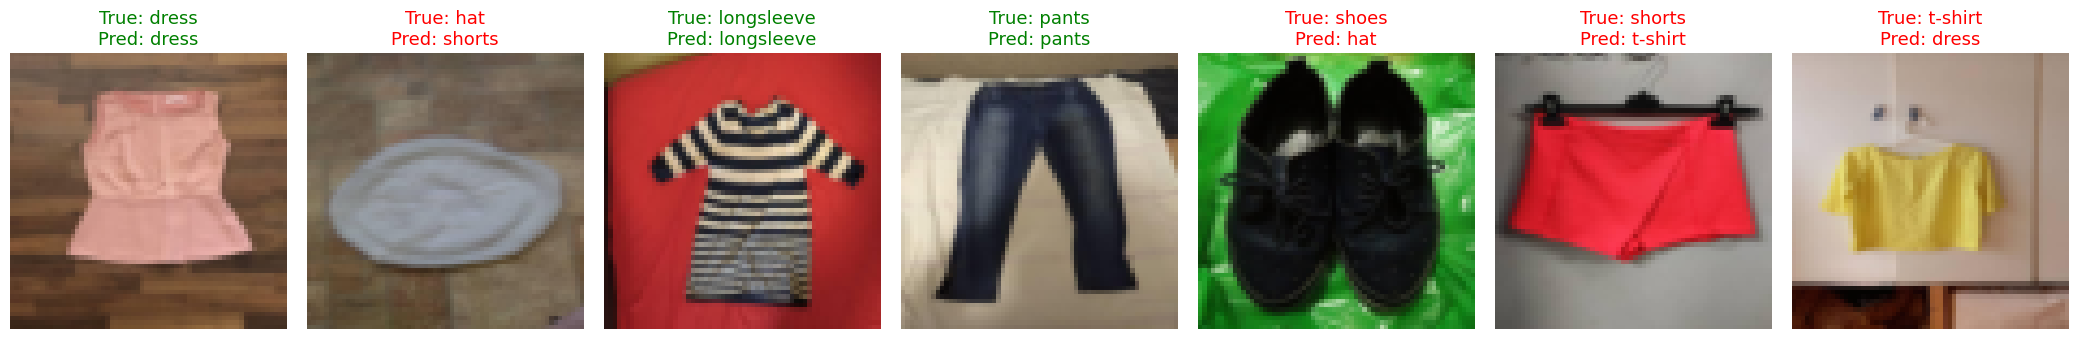

In [24]:
# Display predictions
helper_utils.display_random_predictions_per_class(trained_classifier, val_loader, classes, device)

<a name='2'></a>
## 2 - Building a Visual Search Engine



<a name='2-1'></a>
### 2.1 - Powering Recommendations with Similarity Learning

 prepare the data in a specific way that teaches the model the concept of similarity.

<a name='2-2'></a>
### 2.2 - Teaching Similarity: The Triplet Dataset



In [ ]:
#  TripleDataset

class TripleDataset(Dataset):
    """
    A custom Dataset class that returns triplets of images (anchor, positive, negative).

    This class wraps a standard dataset and, for a given index, returns the 
    item at that index (anchor), a random item with the same label (positive),
    and a random item with a different label (negative).
    """
    
    def __init__(self, dataset):
        """
        Initializes the TripleDataset.

        Args:
            dataset: The base dataset (e.g., torchvision.datasets) 
                     which contains (data, label) pairs.
        """

        # Store the original dataset
        self.dataset = dataset

        # Get a list of all available labels
        self.labels = range(len(dataset.classes))

        # Create a mapping from labels to their corresponding indices in the dataset
        self.labels_to_indices = self._get_labels_to_indices()

    def __len__(self):
        """
        Returns the total number of items in the dataset.
        """
        # The length is the same as the original wrapped dataset
        return len(self.dataset)

    def _get_labels_to_indices(self):
        """
        Creates a dictionary mapping each label to a list of indices.
        
        Returns:
            A dictionary where keys are labels and values are lists of 
            indices in the dataset that have that label.
        """
        # Initialize an empty dictionary
        labels_to_indices = {}
        # Iterate over the entire dataset
        for idx, (_, label) in enumerate(self.dataset):
            # If the label is not yet in the dictionary, add it with an empty list
            if label not in labels_to_indices:
                labels_to_indices[label] = []
            # Append the current index to the list for its label
            labels_to_indices[label].append(idx)
        # Return the completed map
        return labels_to_indices
    

    def _get_positive_negative_indices(self, anchor_label):
        """
        Finds random indices for a positive and a negative sample.

        Args:
            anchor_label: The label of the anchor sample.

        Returns:
            A tuple (positive_index, negative_index).
        """

        

        # Get all indices for the anchor label
        positive_indices = self.labels_to_indices[anchor_label]
        # Randomly select one index from the list of positive indices
        positive_index = random.choice(positive_indices)

        # Get all indices for a negative label
        # Randomly choose a label that is different from the anchor label
        negative_label = random.choice([label for label in self.labels if label != anchor_label]) 
        
        # Get all indices for the chosen negative label
        negative_indices = self.labels_to_indices[negative_label]
        # Randomly select one index from the list of negative indices
        negative_index = random.choice(negative_indices)

        

        return positive_index, negative_index

    def __getitem__(self, idx):
        """
        Retrieves a triplet (anchor, positive, negative) for a given index.

        Args:
            idx: The index of the anchor item.

        Returns:
            A tuple containing the anchor image, positive image, and negative image.
        """

        

        # Get the anchor image and label
        anchor_image, anchor_label = self.dataset[idx]

        # Get positive and negative indices based on the anchor label
        positive_index, negative_index = self._get_positive_negative_indices(anchor_label)

        # Get a positive image (same label)
        positive_image, _ = self.dataset[positive_index]

        # Get a negative image (different label)
        negative_image, _ = self.dataset[negative_index]

        

        return (anchor_image, positive_image, negative_image)


Sample Triplet (Anchor, Positive, Negative):


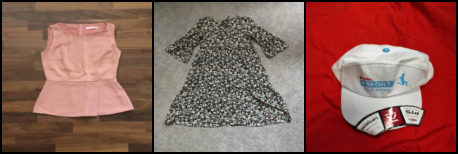

In [26]:
# --- Verification Cell ---
# Set seed for reproducibility of random sampling within the dataset
random.seed(42)

# Create a copy of the validation dataset to use as a base for the toy triplet dataset
toy_dataset_base = copy.deepcopy(validation_dataset)

# Apply a simple transformation
toy_dataset_base.transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Instantiate the TripleDataset using the prepared base dataset
triple_dataset_toy = TripleDataset(dataset=toy_dataset_base)

# Retrieve the first triplet (index 0) from the dataset
anchor_img, positive_image, negative_image = triple_dataset_toy[0]

# Display the triplet
images_list = [anchor_img, positive_image, negative_image]
grid = vutils.make_grid(images_list, nrow=3, padding=2) # nrow=3 ensures side-by-side display
grid_pil = transforms.ToPILImage()(grid)
print("Sample Triplet (Anchor, Positive, Negative):")
display(grid_pil)

In [28]:
# Instantiate the TripleDataset using the main training dataset
triple_dataset = TripleDataset(train_dataset)

# Create a DataLoader for the TripleDataset
siamese_dataloader = torch.utils.data.DataLoader(
    triple_dataset,
    batch_size=32,  # Define the number of triplets per batch
    shuffle=True,
)

<a name='2-3'></a>
### 2.3 - Architecting the Visual Search Model



<a name='2-3-1'></a>
#### 2.3.1 - The Siamese Encoder: Reusing the Backbone



In [29]:
class SiameseEncoder(nn.Module):
    """
    Implements an encoder module suitable for Siamese networks.

    This class takes a pre-defined backbone (feature extractor) and adds a
    representation head (pooling + flatten) to produce a fixed-size vector
    embedding for an input image.
    """

    def __init__(self, backbone):
        """
        Initializes the SiameseEncoder.

        Args:
            backbone (nn.Module): The convolutional neural network to use
                                  as the feature extractor.
        """
        # Initialize the parent nn.Module
        super(SiameseEncoder, self).__init__()

        # Store the provided backbone model
        self.backbone = backbone

        # Define the representation head
        self.representation = nn.Sequential(
            # Apply adaptive average pooling to reduce spatial dimensions to 1x1
            # This makes the output size independent of the input image size (after backbone)
            nn.AdaptiveAvgPool2d(1),
            # Flatten the 1x1 feature map into a 1D vector
            nn.Flatten(),
        )

    def forward(self, x):
        """
        Defines the forward pass through the encoder.

        Args:
            x (torch.Tensor): The input tensor (e.g., a batch of images).

        Returns:
            torch.Tensor: The final 1D embedding vector for the input.
        """
        # 1. Extract features using the backbone
        features = self.backbone(x)
        # 2. Convert feature map to a fixed-size vector using the representation head
        representation = self.representation(features)
        # Return the resulting embedding vector
        return representation

In [30]:
# Create the Siamese Encoder instance
# Reuse the backbone from the classifier model you built earlier!
siamese_encoder = SiameseEncoder(
    backbone=trained_classifier.backbone # Pass the existing backbone
)

<a name='2-3-2'></a>
#### 2.3.2 - The Siamese Network Wrapper



In [31]:
class SiameseNetwork(nn.Module):
    """
    Implements the main Siamese Network structure.

    This network takes multiple inputs (anchor, positive, negative during training)
    and processes each through a shared `embedding_network` (the SiameseEncoder)
    to produce corresponding embeddings.
    """

    def __init__(self, embedding_network):
        """
        Initializes the SiameseNetwork.

        Args:
            embedding_network (nn.Module): The shared encoder network (e.g., SiameseEncoder)
                                           that generates embeddings from images.
        """
        # Initialize the parent nn.Module
        super(SiameseNetwork, self).__init__()
        # Store the shared embedding network
        self.embedding_network = embedding_network

    def forward(self, anchor, positive, negative):
        """
        Defines the forward pass for training with image triplets.

        Args:
            anchor (torch.Tensor): The batch of anchor images.
            positive (torch.Tensor): The batch of positive images (same class as anchor).
            negative (torch.Tensor): The batch of negative images (different class from anchor).

        Returns:
            tuple: A tuple containing the embeddings for anchor, positive, and negative images.
                   (anchor_output, positive_output, negative_output)
        """
        # Process the anchor image through the embedding network
        anchor_output = self.embedding_network(anchor)
        # Process the positive image through the *same* embedding network (shared weights)
        positive_output = self.embedding_network(positive)
        # Process the negative image through the *same* embedding network (shared weights)
        negative_output = self.embedding_network(negative)

        # Return the generated embeddings
        return anchor_output, positive_output, negative_output

    def get_embedding(self, image):
        """
        Generates an embedding for a single input image. Used for inference/retrieval.

        Args:
            image (torch.Tensor): The input image tensor (should include batch dimension).

        Returns:
            torch.Tensor: The embedding vector for the image.
        """
        # Pass the single image through the embedding network
        return self.embedding_network(image)

In [32]:
# Instantiate the Siamese Network
siamese_network = SiameseNetwork(embedding_network=siamese_encoder)

<a name='2-4'></a>
### 2.4 - Training the Siamese Network



In [33]:
# EDITABLE CELL: Feel free to play around with different "margin" and "lr" values

# Define the Triplet Margin Loss function
# margin=1.0: Enforces that the negative sample should be at least 1.0 distance unit farther than the positive sample
# p=2.0: Use Euclidean distance (L2 norm)
loss_fcn = nn.TripletMarginLoss(margin=1.0, p=2.0)

# Define the AdamW optimizer, passing the Siamese network's parameters and a learning rate
optimizer = torch.optim.AdamW(siamese_network.parameters(), lr=0.001)

In [34]:
# EDITABLE CELL:

# Define the number of training epochs
num_epochs = 5

In [35]:
# Run the training loop for the Siamese network
helper_utils.siamese_training_loop(
    # The Siamese model instance
    model=siamese_network,
    # The DataLoader providing triplets
    dataloader=siamese_dataloader,
    # The TripletMarginLoss function
    loss_fcn=loss_fcn,
    # The AdamW optimizer
    optimizer=optimizer,
    # The compute device
    device=device,
    # The number of epochs to train
    n_epochs=num_epochs,
)


--- Starting Siamese Training ---


Epoch 1/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/5 finished, Average Loss: 0.7818
    -> New best model saved (Epoch 1, Loss: 0.7818)


Epoch 2/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/5 finished, Average Loss: 0.7186
    -> New best model saved (Epoch 2, Loss: 0.7186)


Epoch 3/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/5 finished, Average Loss: 0.6775
    -> New best model saved (Epoch 3, Loss: 0.6775)


Epoch 4/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/5 finished, Average Loss: 0.6635
    -> New best model saved (Epoch 4, Loss: 0.6635)


Epoch 5/5:   0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/5 finished, Average Loss: 0.6507
    -> New best model saved (Epoch 5, Loss: 0.6507)

--- Siamese Training Complete ---
Loaded best model weights from Epoch 5 with lowest loss: 0.6507


<a name='2-5'></a>
### 2.5 - Performing Visual Search (Retrieval)



In [36]:
# Display the widget for uploading JPG images
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg,.jpeg', description='Upload JPG (Max 5MB)')

Output()

In [ ]:
# EDITABLE CELL: Set the path for your query image

image_path = './images/t_shirt.jpg' 

Query Image:


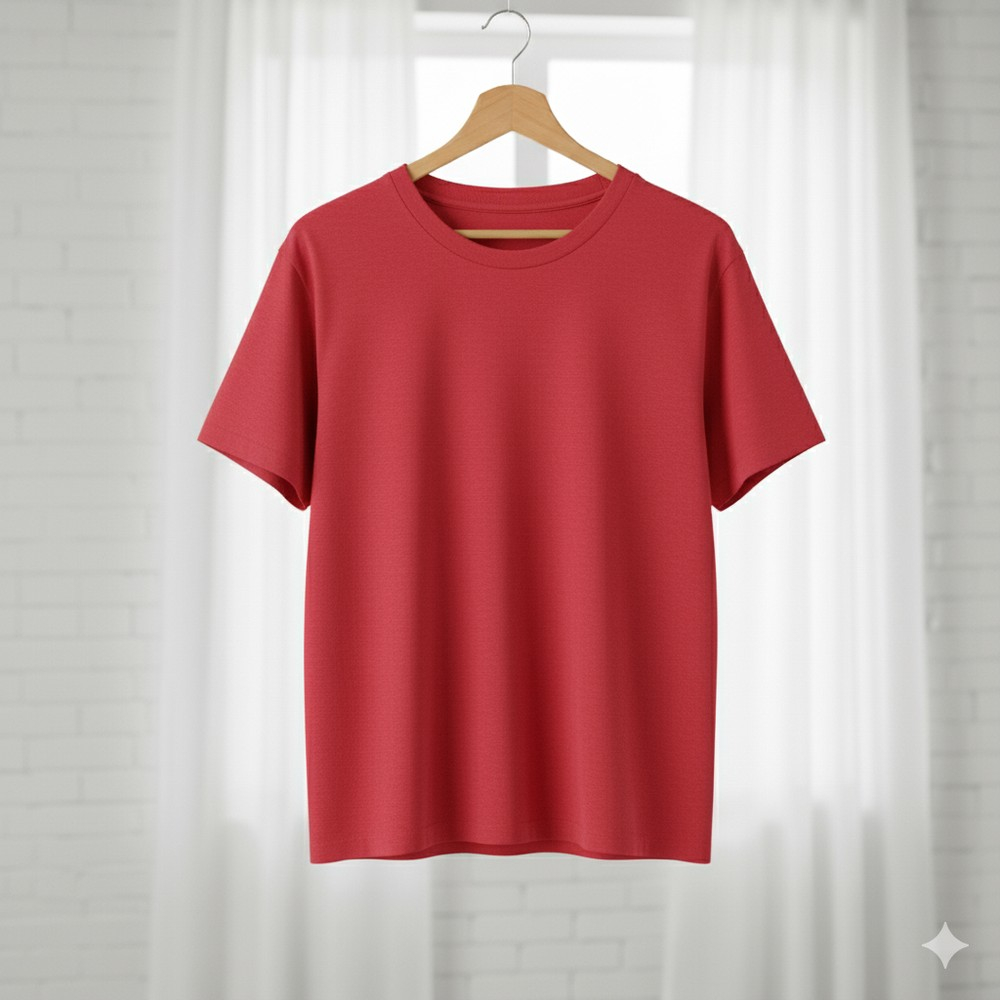

In [38]:
# Load the selected image using the helper function
query_img = helper_utils.get_query_img(image_path)
# Display the query image
print("Query Image:")
display(query_img)

In [39]:
def get_query_img_embedding(encoder, transform, img, device):
    """
    Generates an embedding vector for a single query PIL image.

    Args:
        encoder (nn.Module): The trained embedding model (e.g., SiameseEncoder).
        transform (callable): The torchvision transforms to apply (e.g., resize, normalize).
        img (PIL.Image): The input query image.
        device (torch.device): The device ('cuda' or 'cpu') to perform inference on.

    Returns:
        np.ndarray: The embedding vector as a NumPy array.
    """
    # Apply the transformations (resize, ToTensor, normalize)
    tensor_img = transform(img)

    # Add a batch dimension (B, C, H, W) as the model expects batches
    # and move the tensor to the specified device
    query_img_tensor = tensor_img.unsqueeze(0).to(device)

    # Set the encoder to evaluation mode (important for layers like BatchNorm, Dropout)
    encoder.eval()
    # Perform inference without calculating gradients to save memory and computation
    with torch.no_grad():
        # Pass the image tensor through the encoder model
        query_img_embedding = encoder(query_img_tensor)

    # Move the resulting embedding tensor from the device (e.g., GPU) back to the CPU
    # and convert it into a NumPy array for easier handling (e.g., distance calculations)
    query_img_embedding_np = query_img_embedding.cpu().numpy()
    # Return the embedding as a NumPy array
    return query_img_embedding_np

In [40]:
# Generate the embedding for the sample query image
query_img_embedding = get_query_img_embedding(siamese_encoder, val_transform, query_img, device)

# Print the shape of the resulting embedding vector (should be [1, embedding_dim])
print("Shape of query image embedding:", query_img_embedding.shape)

Shape of query image embedding: (1, 64)


In [41]:
# Use the validation dataset as the "catalog" of items to search within
catalog = validation_dataset

# Use a helper function to efficiently generate embeddings for all items in the catalog
print("Generating embeddings for the catalog...")
embeddings = helper_utils.get_embeddings(siamese_encoder, catalog, device)
print(f"Generated {len(embeddings)} embeddings for the catalog.")

Generating embeddings for the catalog...
Generated 276 embeddings for the catalog.


#### Finding and Displaying Similar Items

* With embeddings generated for the query and the entire catalog, use the `find_closest` helper function to identify the indices of the `num_samples` most similar images in the catalog based on Euclidean distance.

In [42]:
# EDITABLE CELL: # Define how many similar items to retrieve

num_samples = 5

In [ ]:
# Use a helper function to find the indices of the items in the catalog
# whose embeddings are closest (smallest Euclidean distance) to the query embedding
print(f"Finding the top {num_samples} closest items...")
closest_indices = helper_utils.find_closest(embeddings, query_img_embedding, num_samples)
print("Indices of closest items:", closest_indices)

In [ ]:
# Loop through the indices of the closest images found
print(f"\nDisplaying the {num_samples} most similar items found in the catalog:")
for idx_c in closest_indices:
    # Retrieve the image and its true label from the catalog dataset using the index
    # The helper function likely handles converting tensor back to displayable format
    img_c, label_idx_c = helper_utils.get_image(catalog, idx_c) # Assuming get_image returns PIL + label index
    label_c = catalog.classes[label_idx_c] # Get class name from index
    # Print the class label of the retrieved image
    print(f"Retrieved Item - Class: {label_c} (Index: {idx_c})")
    # Display the retrieved image
    display(img_c)